In [1]:
from IPython import display

# Domestic Perception Functionalities

This tutorial will discuss the overall perception architecture and various utilities for processing point clouds and images existing in the `mas_perception_libs` package.

The code portions in this tutorial for the [Pose Estimation](#Pose-Estimation) section assume successful installation of the ROS package [`mas_perception_libs`](https://github.com/b-it-bots/mas_perception/blob/devel/mas_perception_libs/) as well as `numpy` and `matplotlib`.

The code in the [SSD Object Detection](#SSD-Object-Detection) section assumes installation of  [`ssd_keras_ros`](https://github.com/minhnh/ssd_keras_ros), the Python dependencies `keras`, `tensorflow` & `tqdm`, and Git LFS initialization (also described in the package documentation).

We will mostly focus on object detection, since person recognition is somewhat separated from the other components and should be refactored to use `mas_perception` architecture. Because of ROS limitations, a Python 2 kernel should be used in order for the ROS packages to load properly.

## Table of contents
* [Architecture Overview](#Architecture-Overview)
    - [Object Detection](#Object-Detection)
    - [Object Recognition](#Object-Recognition)
* [`mas_perception_libs`](#mas_perception_libs)
    - [Extract an OpenCV Image from a `sensor_msgs/PointCloud2` Object](#Extract-an-OpenCV-Image-from-a-sensor_msgs/PointCloud2-Object)
    - [Pose Estimation](#Pose-Estimation)
    - [SSD Object Detection](#SSD-Object-Detection)
    - [Point Cloud Processing](#Point-Cloud-Processing)

## Architecture Overview

### Object Detection

Previously, the object detection in `mcr_scene_segmentation` and the built-in `tabletop_segmentator` on the HSR had the following general structure

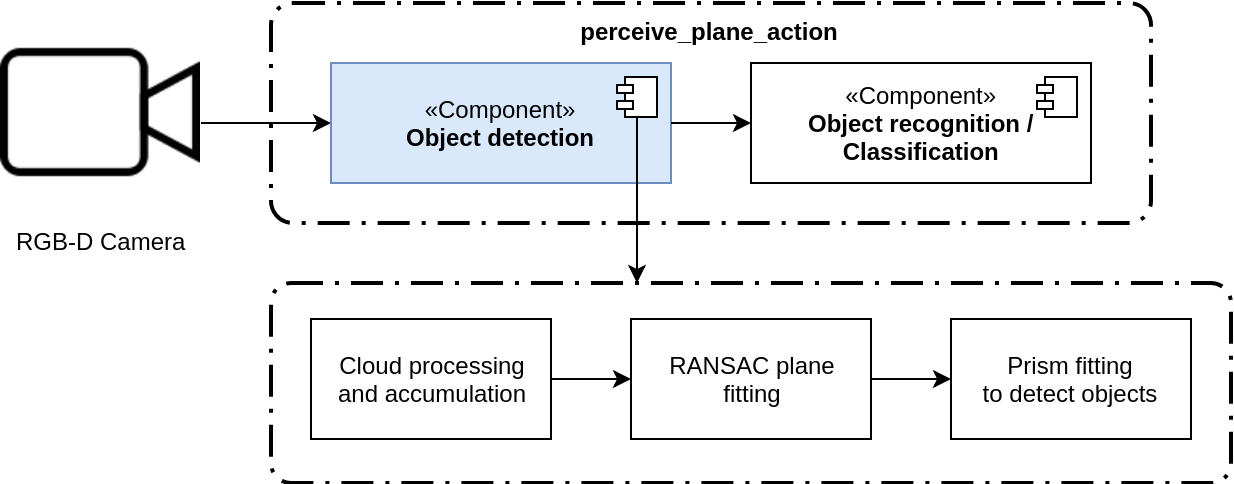

In [2]:
display.Image('images/perception_arch_detection_old.png', width=600)

In the @Home team, this architecture was modified as shown in the following figure:

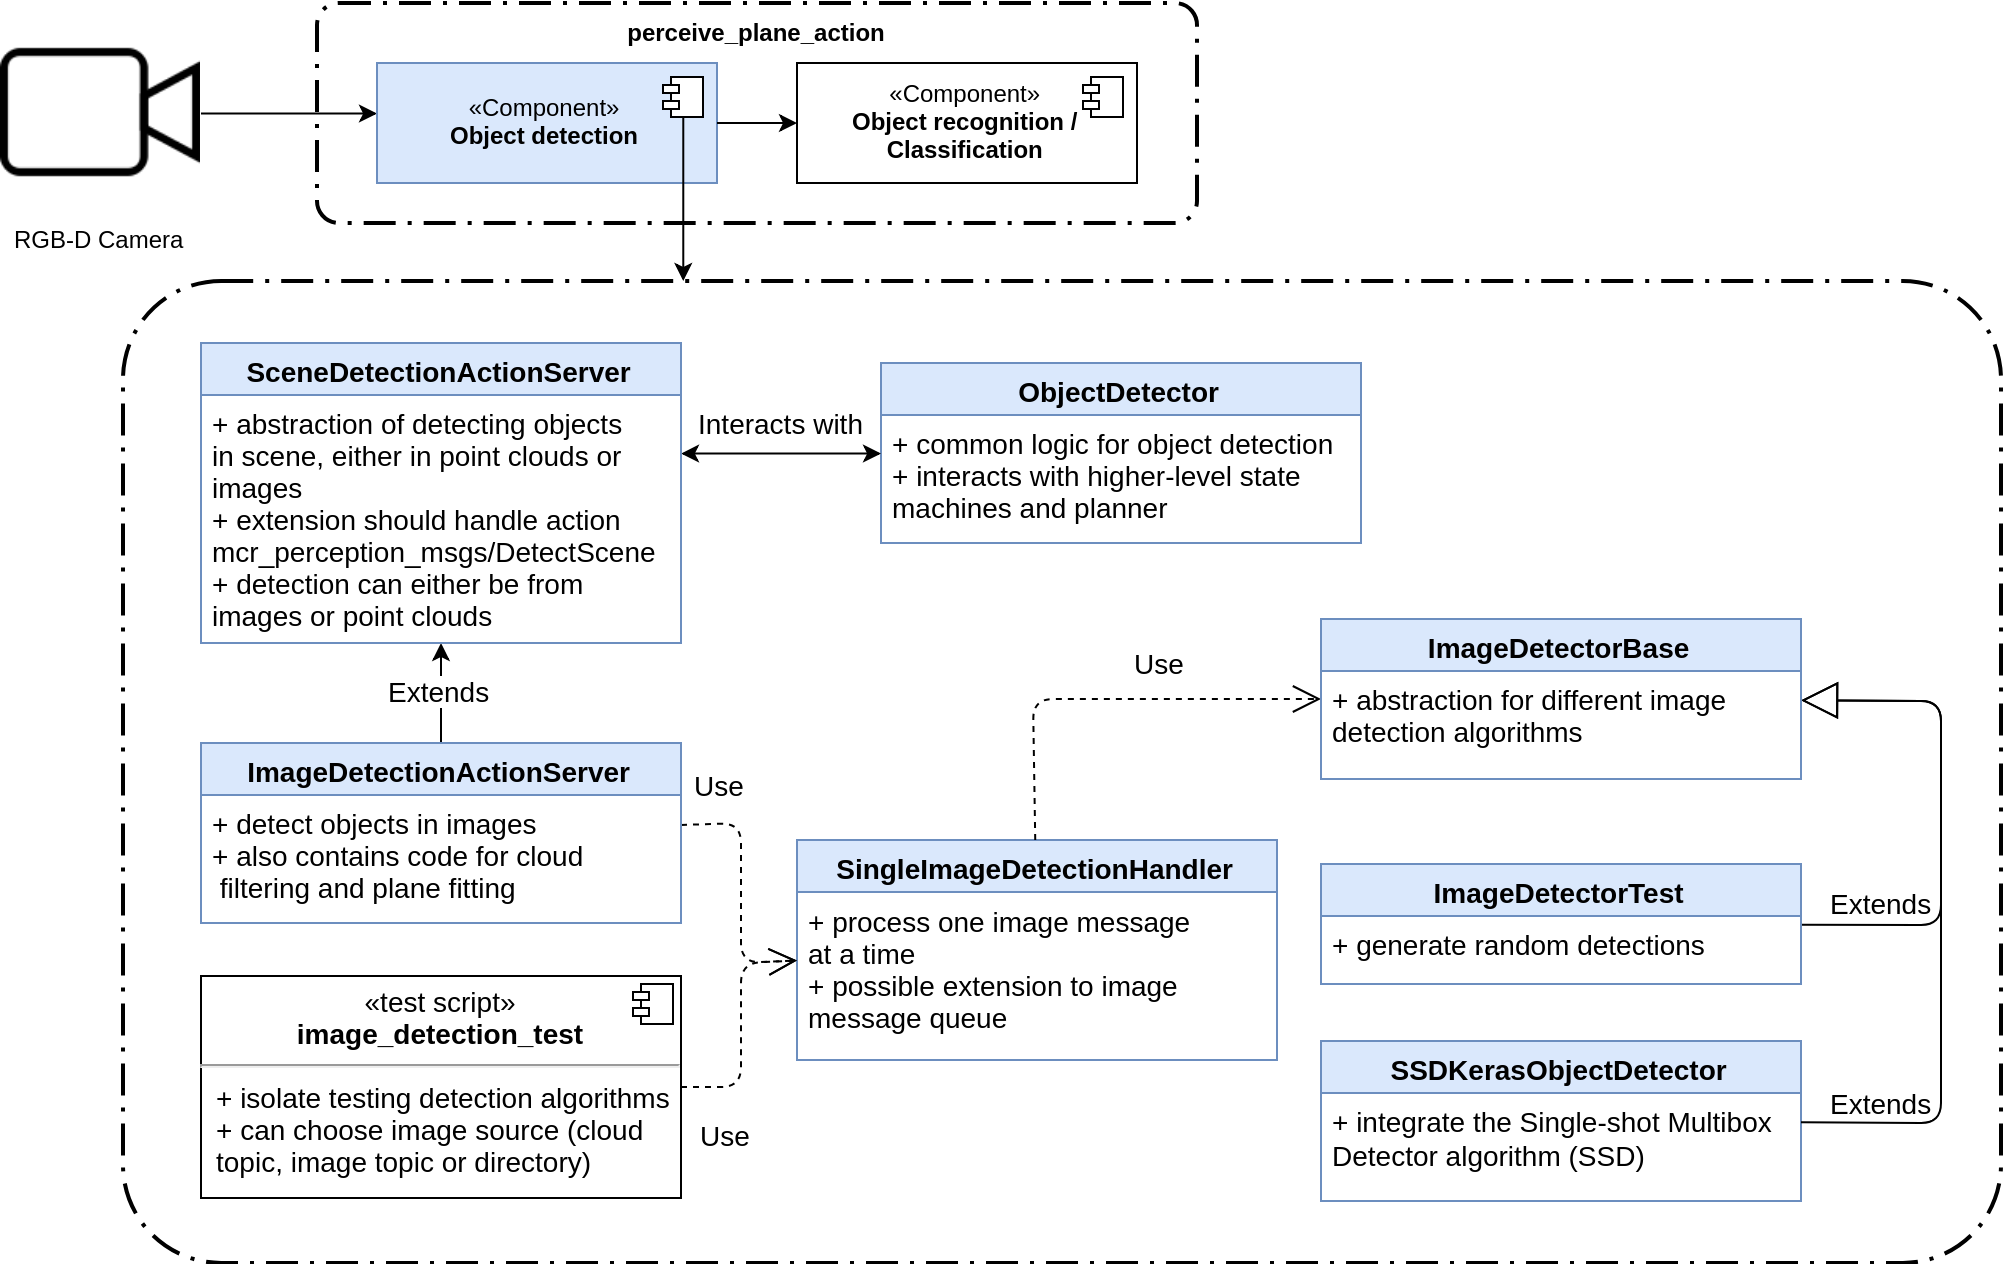

In [3]:
display.Image('images/perception_arch_detection_new.png')

There are several motivations for moving away from the older solution and going for this design:
* Relying solely on point clouds for detection is not always reliable, especially in domestic environment, because of the variety of materials and object shapes. For example, RGB-D cameras have a particularly hard time with plastic objects, as can be seen in the figure below.
* Exciting new detection algorithms tend to deal with RGB-only images, which are often less affected by object materials. However, many of these use deep learning (DL) libraries in Python, whereas the old detection code is written in C++.
* The fast moving pace of DL demands some form of abstraction for easing integration of new algorithms.

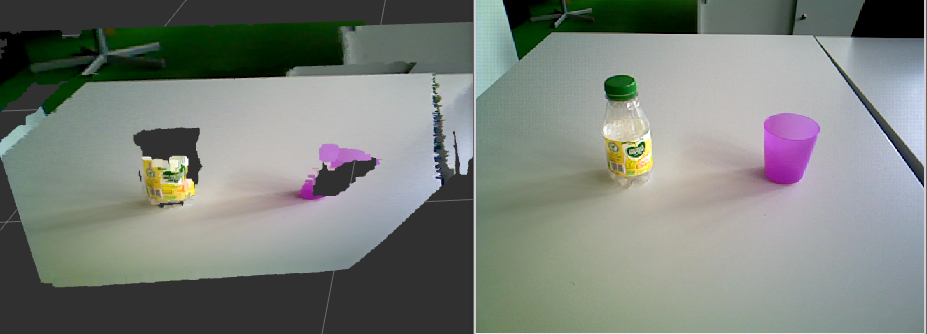

In [4]:
display.Image('images/bad_objects.png')

With the above points in mind, the main features of this architecture are:
* `ObjectDetector` (see the [Python documentation](https://github.com/b-it-bots/mas_perception/blob/devel/mas_perception_libs/docs/python_package.md#objectdetector) for more details) is an abstraction which interacts with higher-level state machines and planning logic.
    - It also works with the HSR built-in `tabletop_segmentator` component (this has not been tested since mid 2018, however).
    - A similar detection action server which uses `mcr_scene_segmentation` can be implemented without much effort and would be able to interact with `ObjectDetector`, as long as it properly handles the action defined in [`mcr_perception_msgs/DetectScene.action`](https://github.com/b-it-bots/mas_perception/blob/kinetic/mcr_perception_msgs/action/DetectScene.action).
* `SceneDetectionAction` is an abstraction for a handler of the `mcr_perception_msgs/DetectScene` action. The interaction with HSR's `tabletop_segmentator`, for example, is handled in an extension of this class. Extensions of this class are meant to have direct access to sensor topics for efficiency.
* `ImageDetectorBase` (see the [Python documentation](https://github.com/b-it-bots/mas_perception/blob/devel/mas_perception_libs/docs/python_package.md#imagedetectorbase) for more details) is an abstraction for different image detection algorithms, which would hopefully ease the integration of new algorithms in the future.

Possible improvements for the object detection architecture:
* Combining the point cloud detection and image detection for a more robust solution can be done in an extension of `SceneDetectionAction`.
* `mcr_perception_msgs/DetectScene` and `SceneDetectionAction` can be more general; in particular, detecting objects without being attached to a plane, detecting people, as well as handling scene/semantic segmentation would all be useful additions.
* `SingleImageDetectionHandler` can be extended to handle multiple images (possibly a queue model).
* Currently, `ImageDetectionActionServer` handles cloud processing code such as plane fitting, cloud filtering, and object pose estimation. Pose estimation may need to be refactored to a different location, if more advanced methods are to be integrated.

### Object Recognition

The following figure shows the architecture of the image recognition/classification component. The main features are:
* Common proxy and service for the [`ImageRecognition` service](https://github.com/b-it-bots/mas_perception./blob/devel/mcr_perception_msgs/srv/ImageRecognition.srv) for handling all image classification models
* `RecognizeImageService` loads all classification models from a directory; the service request specifies which model to use for classification.
* `ImageRecognitionServiceProxy` specifies which model to use in service requests in the constructor.

Possible improvements:
* Load all models during initialization in `RecognizeImageService` to avoid slow classification of first service request.
* Change `ImageRecognitionService` to `RecognizeImage` for consistency with other service names (minor).
* Use an action server instead of a service for consistency with the image detection component (minor).

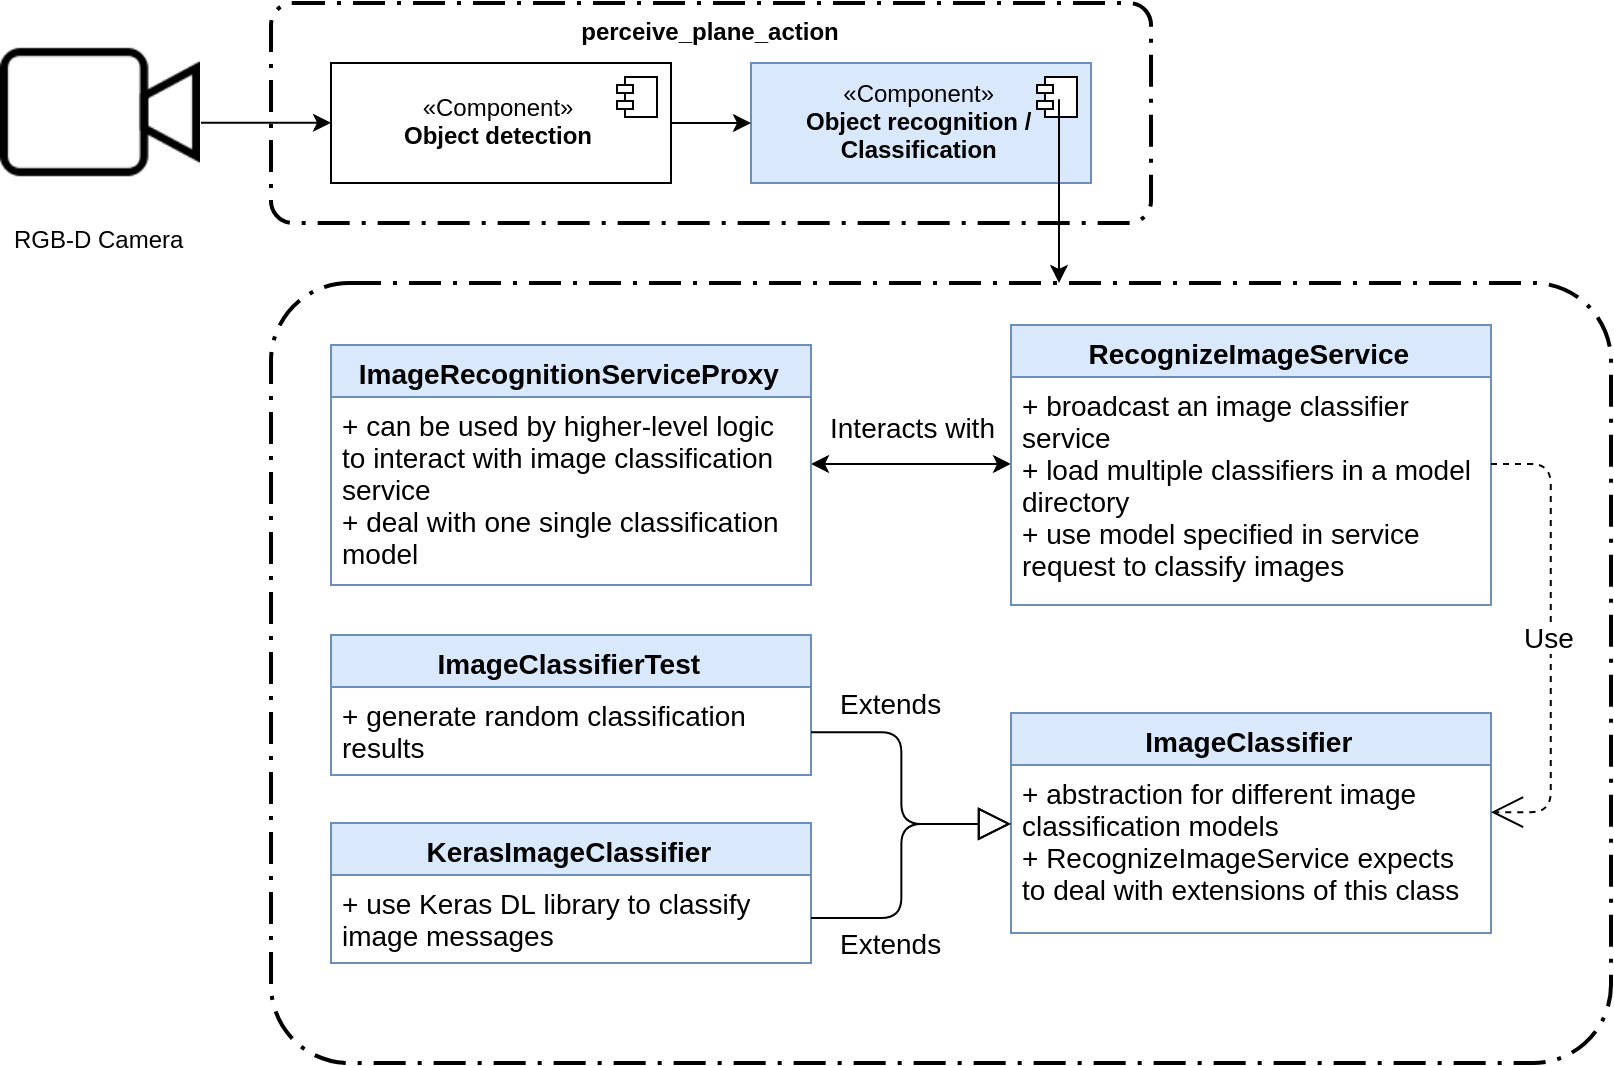

In [5]:
display.Image('images/perception_arch_recognition.png', width=750)

## `mas_perception_libs`

[`mas_perception_libs`](https://github.com/b-it-bots/mas_perception/blob/devel/mas_perception_libs/) is where almost all of the above components are defined (except for `SSDKerasObjectDetector`). Other than architectural code, the library also provides a common API for several functionalities in both C++ and Python, most notably point cloud processing.

The following code section loads in `sensor_msgs/PointCloud2` ROS messages from a bag file into a list. We will then experiment with one of these clouds. Because the quirky `rosbag` apparently stores messages in some mutated definition of the original messages, there's the need to serialize and then deserialize the message for our next steps.

While this is not particularly important to our perception functionalities, it's worthy to note that `from_cpp` and `to_cpp`, which are utility functions defined in [`mas_perception_libs`](https://github.com/b-it-bots/mas_perception/blob/devel/mas_perception_libs/ros/src/mas_perception_libs/ros_message_serialization.py), imitate ROS serialization of messages. These and their sister functions in C++ are how the Python functions are able to call C++ code on all ROS messages. In addition, any custom C++ object (e.g. [BoundingBox](https://github.com/b-it-bots/mas_perception/blob/devel/mas_perception_libs/docs/python_package.md#boundingbox2d)) has to be implemented manually with [Boost-Python](https://boostorg.github.io/python/doc/html/index.html) (or alternatives) to be used in Python.

In [6]:
import rosbag
from sensor_msgs.msg import PointCloud2
from mas_perception_libs.utils import from_cpp, to_cpp

cloud_bag = rosbag.Bag('data/sample_cloud.bag')
bag_topics = cloud_bag.get_type_and_topic_info()[1]
pointclouds = []
for topic, msg, t in cloud_bag.read_messages():
    if topic not in bag_topics or bag_topics[topic].msg_type != 'sensor_msgs/PointCloud2':
        continue
    pointclouds.append(msg)
cloud_bag.close()
cloud_msg = pointclouds[0]

print('Oh no type doesn\'t match:\t type(cloud_msg) == PointCloud2 ? ' + str(type(cloud_msg) == PointCloud2))
print('Actual type:\t\t\t type(cloud_msg) = ' + str(type(cloud_msg)))

# some trickery required for converting the rosbag message type to the original type
cloud_msg = from_cpp(to_cpp(cloud_msg), PointCloud2)

print('All is good now:\t\t type(cloud_msg) == PointCloud2 ? ' + str(type(cloud_msg) == PointCloud2))

Oh no type doesn't match:	 type(cloud_msg) == PointCloud2 ? False
Actual type:			 type(cloud_msg) = <class 'tmpTV2Olt._sensor_msgs__PointCloud2'>
All is good now:		 type(cloud_msg) == PointCloud2 ? True


### Extract an OpenCV Image from a `sensor_msgs/PointCloud2` Object

The following code illustrates how to use `cloud_msg_to_cv_image` to extract an image in the form of a NumPy array from a `sensor_msgs/PointCloud2`.

Image shape: (480, 640, 3), <type 'numpy.ndarray'>


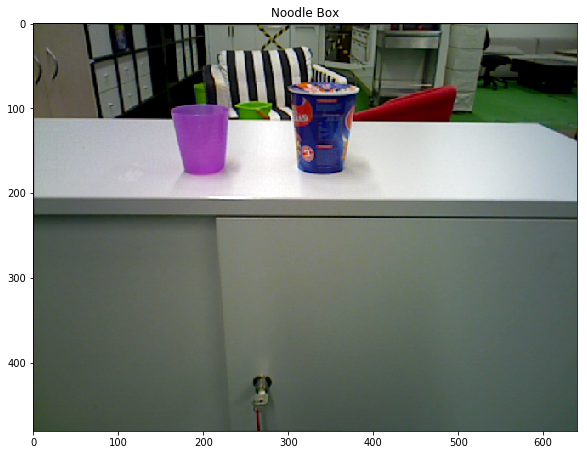

In [7]:
%matplotlib inline
from matplotlib import pyplot as plt
import cv2
from mas_perception_libs.utils import cloud_msg_to_cv_image

def display_image(img, fig_width, title):
    fig_width = float(fig_width)
    height, width, _ = img.shape
    fig = plt.figure(figsize=(fig_width, fig_width / width * height))
    plt.imshow(img)
    plt.title(title)
    plt.show()

cv_image = cloud_msg_to_cv_image(cloud_msg)
print('Image shape: {0}, {1}'.format(cv_image.shape, type(cv_image)))

# OpenCV has BGR instead of the RGB encoding that matplotlib expects
cv_image = cv2.cvtColor(cv_image, cv2.COLOR_BGR2RGB)
display_image(cv_image, 10, 'Noodle Box')

### Pose Estimation

Here, we try to fit a pose to the noodle box using a very educated guess of where it is in the image. In other words, what we are doing here would, in practice, follow object detection and recognition.

First, we create the detection region using the `BoundingBox2D` class which [is defined in C++](https://github.com/b-it-bots/mas_perception/blob/devel/mas_perception_libs/docs/cpp_library.md#boundingbox2d) and ported to Python for a common API.

We can visualize this box using the `draw_labeled_boxes` function for OpenCV images, or `draw_labeled_boxes_img_msg` for `sensor_msgs/Image` objects.

Note that these visualization functions call a [C++ function](https://github.com/minhnh/mas_perception/blob/devel/mas_perception_libs/common/include/mas_perception_libs/bounding_box_2d.h#L53), which has the following signature:
```cpp
void drawLabeledBoxes(cv::Mat &pImage, std::vector<BoundingBox2D> pBoundingBoxes,
                      int pThickness = 2, double pFontScale = 1.0);
```

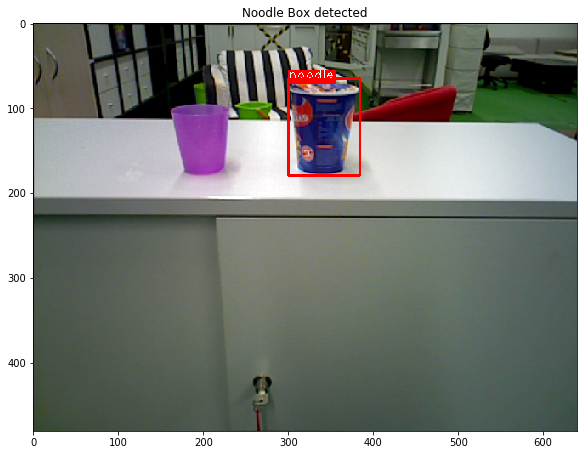

In [8]:
from mas_perception_libs import BoundingBox2D
from mas_perception_libs.visualization import draw_labeled_boxes

# detect regions in the image to get a bounding box
detection = BoundingBox2D(label='noodle', box_geometry=(300, 65, 85, 115))  # (x, y, width, height)

# visualize the box in the image
drawn_image = draw_labeled_boxes(cv_image, [detection])
display_image(drawn_image, 10, 'Noodle Box detected')

Given the `BoundingBox2D` object, we can then use `crop_cloud_to_xyz` to extract the 3D coordinates of the points within this bouding box region. Pose estimation can then be done using `np.nanmean`. Note that `nanmean` will ignore `np.nan` values in the array.

Note that `crop_cloud_to_xyz` also calls a [C++ function](https://github.com/minhnh/mas_perception/blob/devel/mas_perception_libs/ros/include/mas_perception_libs/point_cloud_utils.h#L31), which has the following signature:
```cpp
cv::Mat cropCloudMsgToXYZ(const sensor_msgs::PointCloud2 &pCloudMsg, BoundingBox2D &pBox);
```

In [9]:
import numpy as np
from mas_perception_libs.utils import crop_cloud_to_xyz

# crop cloud for coordinates and estimate pose
cropped_coord = crop_cloud_to_xyz(cloud_msg, detection)
mean_pose = np.nanmean(np.reshape(cropped_coord, (-1, 3)), axis=0)
print('estimated noodle box pose (frame {0}): x={1:.3f}, y={2:.3f}, z={3:.3f}'
      .format(cloud_msg.header.frame_id, mean_pose[0], mean_pose[1], mean_pose[2]))

estimated noodle box pose (frame camera_link): x=0.029, y=-0.179, z=0.796


### SSD Object Detection

The following code block loads the `SSDKerasObjectDetector` class, uses the appropriate configuration files, and performs detection on the image extracted from the `sensor_msgs/PointCloud2` message.

`SSDKerasObjectDetector` is an extension of [`ImageDetectorBase`](https://github.com/minhnh/mas_perception/blob/devel/mas_perception_libs/docs/python_package.md#imagedetectorbase), which is used by [`SingleImageDetectionHandler`](https://github.com/minhnh/mas_perception/blob/devel/mas_perception_libs/docs/python_package.md#singleimagedetectionhandler) as can be seen in [the figure above](#Object-Detection).

`SSDKerasObjectDetector.detect()` expects a list of `sensor_msgs/Image` objects, so the `cloud_msg_to_image_msg` function is used to extract an image message from a `sensor_msgs/PointCloud2` message.

`SSDKerasObjectDetector.detect()` returns a list of detections for each image message. Each detection is a dictionary containing the detected class, detection confidence, and box pixel geometry, as printed out below. The keys of this dictionary are `Enum` values of `ImageDetectionKey` as shown below.

In [10]:
import os
from rospkg import RosPack
from mas_perception_libs import ImageDetectionKey
from mas_perception_libs.utils import cloud_msg_to_image_msg

# suppress tensorflow warning messages
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

from ssd_keras_ros import SSDKerasObjectDetector

# use RosPack to point to appropriate configuration files
rp = RosPack()
package_path = rp.get_path('ssd_keras_ros')
class_ann_file = os.path.join(package_path, 'models', 'coco_classes.yml')
kwargs_file = os.path.join(package_path, 'models', 'ssd_keras_object_detector_kwargs.yml')

# create SSDKerasObjectDetector object and call detection on 
detector = SSDKerasObjectDetector(class_file=class_ann_file, model_kwargs_file=kwargs_file)
predictions = detector.detect([cloud_msg_to_image_msg(cloud_msg)])

pred = predictions[0][0]
for enum_name, enum in ImageDetectionKey.__members__.iteritems():
    print('{}: {}'.format(enum_name, pred[enum]))

Using TensorFlow backend.


CLASS: cup
CONF: 0.953528821468
X_MIN: 161.73819987
X_MAX: 231.004378255
Y_MIN: 94.8230712891
Y_MAX: 176.401989746


`ImageDetectorBase.prediction_to_bounding_boxes()` can convert the above dictionary into `BoundingBox2D` objects, which can be used for the visualization function. `class_colors` is automatically generated for the classes. A similar image is published by `SingleImageDetectionHandler` on the topic `/mas_perception/detection_result` after each detection.

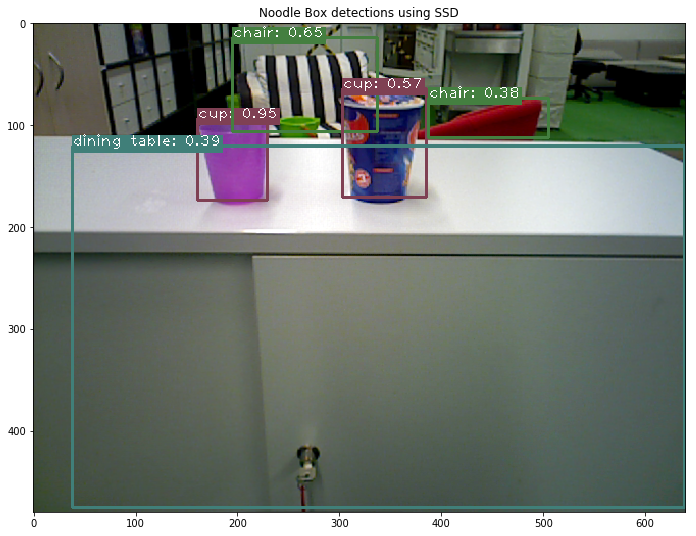

In [11]:
from mas_perception_libs import ImageDetectorBase

bounding_boxes, classes, confidences \
            = ImageDetectorBase.prediction_to_bounding_boxes(predictions[0], detector.class_colors)

ssd_image = draw_labeled_boxes(cv_image, bounding_boxes)
display_image(ssd_image, 12, 'Noodle Box detections using SSD')

### Point Cloud Processing

There are two main point cloud processing functionalities that are refactored from `mcr_scene_segmentation` to `mas_perception_libs`, namely cloud filtering and plane segmentation. These are defined in the C++ class [`PlaneSegmenterROS`](https://github.com/b-it-bots/mas_perception/blob/devel/mas_perception_libs/ros/include/mas_perception_libs/point_cloud_utils_ros.h#L69) as well as the ROS-independent [`CloudFilter`](https://github.com/b-it-bots/mas_perception/blob/devel/mas_perception_libs/common/include/mas_perception_libs/point_cloud_utils.h#L55) and [`SacPlaneSegmenter`](https://github.com/b-it-bots/mas_perception/blob/devel/mas_perception_libs/common/include/mas_perception_libs/sac_plane_segmenter.h#L63). A Python interface called [`PlaneSegmenter`](https://github.com/b-it-bots/mas_perception/blob/devel/mas_perception_libs/ros/src/mas_perception_libs/utils.py#L16) is also developed. Detailed API descriptions are in the comments of the linked files.

The main motivation for preprocessing point clouds is because they are huge, and not all points are necessarily relevant to what we're trying to observe. This can be seen in the Rviz screenshot below.

Two launch files are available for testing the point cloud processing functionalities in C++ and Python: `cloud_processing_cpp_test.launch` and `cloud_processing_python_test.launch`. Full description of the launch file arguments are available in the [`mas_perception_libs` documentation](https://github.com/b-it-bots/mas_perception/tree/devel/mas_perception_libs#cloud_processing_python_test). Notably, the `bool` argument `extract_planes` will specify to also run plane segmentation on top of cloud filtering.

This section will not include code cells because these components require parameterization corresponding to a specific frame, which is not in the scope of this tutorial.

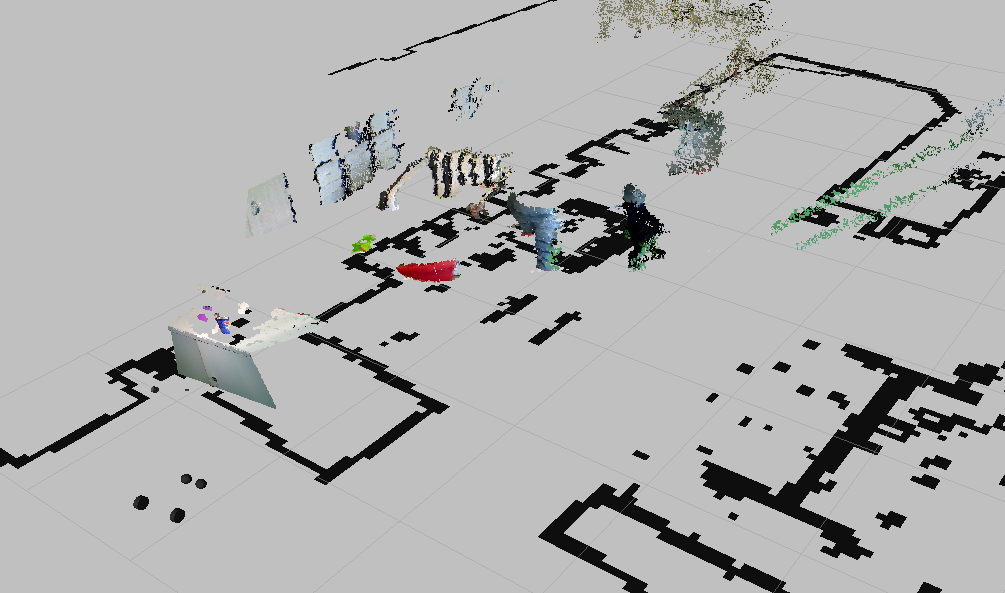

In [12]:
display.Image('images/pointcloud_raw.png')

Cloud filtering reduces the above cloud to the one below. This is done in two steps:
* Pass-through filter: limit the point cloud along the three Cartesian axes of a specified reference frame (normally in the cloud header)
* Voxel filter: down-sample the point cloud by grouping adjacent points together

Python usage:
```Python
from mas_perception_libs.utils import PlaneSegmenter

plane_segmenter = PlaneSegmenter()
filtered_cloud = plane_segmenter.filter_cloud(cloud_msg)
```
C++ usage:
```cpp
#include <mas_perception_libs/point_cloud_utils_ros.h>

PlaneSegmenterROS planeSegmenter;
sensor_msgs::PointCloud2::ConstPtr& cloudMsgPtr;  // generally received in the point cloud callback
sensor_msgs::PointCloud2::Ptr filteredCloudPtr = planeSegmenter.filterCloud(cloudMsgPtr);
```

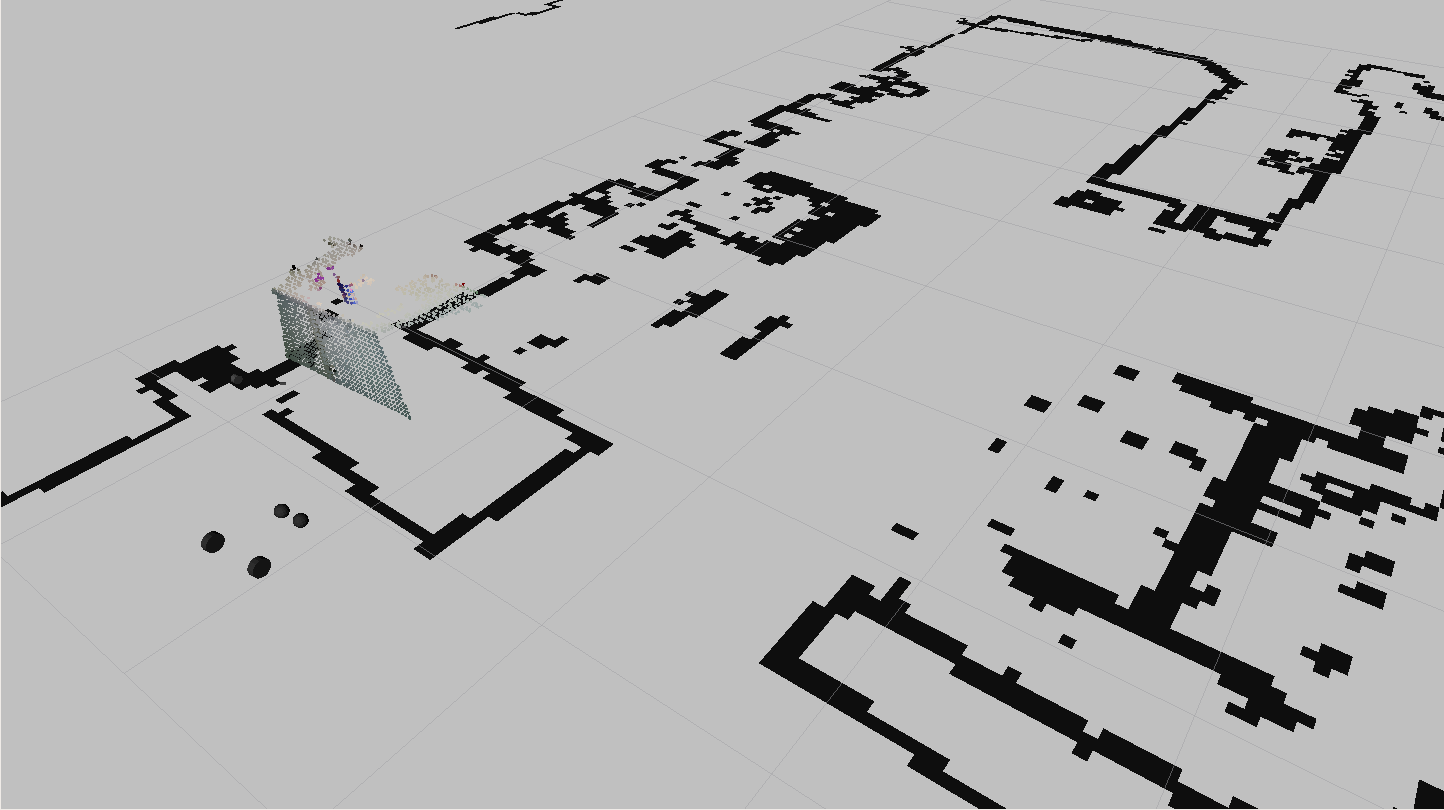

In [13]:
display.Image('images/pointcloud_filtered.png')

If `extract_planes` is set to `true` when launching the cloud processing test executables, a RANSAC algorithm will be used to fit a plane to the filtered point cloud above. A `visualization_msgs/Marker` message will be published on the `~detected_planes` topic for the C++ node (and unfortunately `~plane_convex_hull` for the Python node), as can be seen in the figure below.

A utility function to create a `visualization_msgs/Marker` message from a `mcr_perception_msgs/Plane` message is available in both C++ and Python.

Python usage:
```Python
from mas_perception_libs.visualization import plane_msg_to_marker

plane_list, processed_cloud = plane_segmenter.find_planes(cloud_msg)
assert type(plane_list) == mcr_perception_msgs.msg.PlaneList
marker = plane_msg_to_marker(plane_list.planes[0], 'plane_convex')
```
C++ usage:
```cpp
#include <mas_perception_libs/point_cloud_utils_ros.h>

PlaneSegmenterROS planeSegmenter;

sensor_msgs::PointCloud2::Ptr cloudMsgPtr, filteredCloudPtr;
mcr_perception_msgs::PlaneList::Ptr
planeListPtr = planeSegmenter.findPlanes(cloudMsgPtr, filteredCloudPtr);

visualization_msgs::Marker::Ptr
planeMarkerPtr = planeMsgToMarkers(planeListPtr->planes[0], "planar_polygon");
```

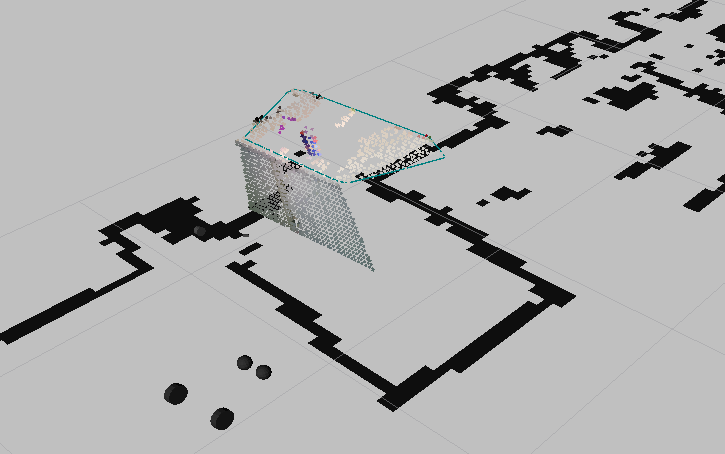

In [14]:
display.Image('images/pointcloud_plane_marker.png')

Dynamic configuration is written for point cloud processing functionalities and defined in [`PlaneFitting.cfg`](https://github.com/b-it-bots/mas_perception/blob/devel/mas_perception_libs/ros/config/PlaneFitting.cfg). To view the configuration window as seen in the figure below, execute the following command:
```bash
$ rosrun rqt_reconfigure rqt_reconfigure
```

This is handled by both the cloud processing test nodes and the `SceneDetectionAction` action server. The parameters passed to the dynamic configuration server can be used for configuring the cloud processing as follows:

Python usage:
```Python
plane_segmenter.set_params(config)
```

C++ usage:
```cpp
PlaneFittingConfig &config;
planeSegmenter.setParams(config);
```

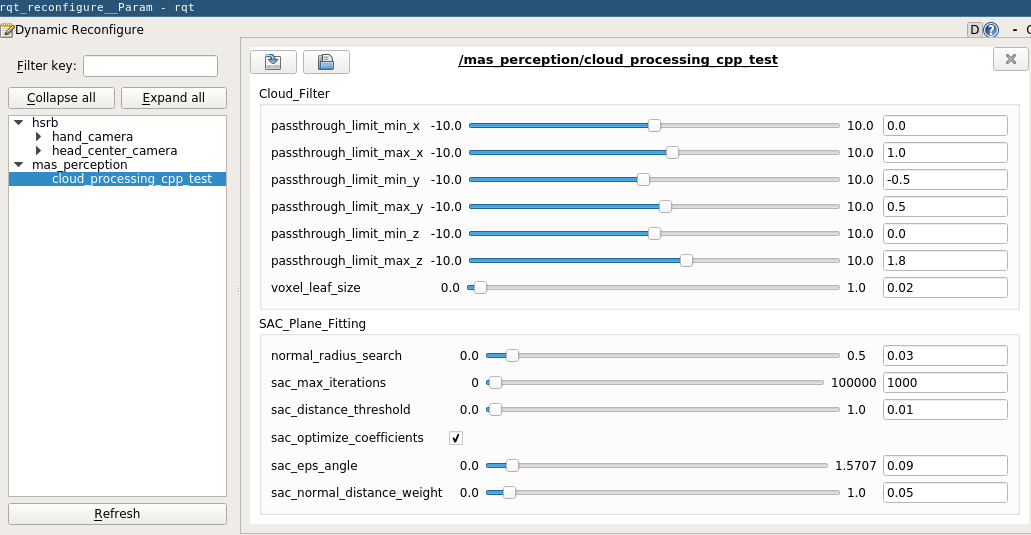

In [15]:
display.Image('images/pointcloud_params.png')

## About This Tutorial

**Author(s)**: Minh Nguyen

**Contributors**: Alex Mitrevski

**Last update**: 08.03.2019